In [ ]:
!pip install gym-anytrading
!pip install tensorflow

     |████████████████████████████████| 171 kB 17.4 MB/s 
     |████████████████████████████████| 462 kB 12.6 MB/s 


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import random
import tensorflow as tf
import gym
import gym_anytrading
from gym_anytrading.datasets import STOCKS_GOOGL
import matplotlib.pyplot as plt
from keras.models import Sequential
from collections import deque
from keras.layers import Activation, Dense
from keras.layers import Flatten 
from sklearn import preprocessing
from sklearn.preprocessing import normalize
import random


In [ ]:
class DqnAgent:
  def __init__(self,model_location='/content/DQN_model'):
    
    self.q_net = self._build_dqn_model()
    self.model_location = model_location
    self.checkpoint = tf.train.Checkpoint(step=tf.Variable(0), net=self.q_net)
    self.checkpoint_manager = tf.train.CheckpointManager(self.checkpoint, 'checkpoints200', max_to_keep=10)
    # self.checkpoint_manager = tf.train.CheckpointManager(self.checkpoint, 'checkpoints2000', max_to_keep=10)
    self.load_checkpoint()
    self.target_q_net = self._build_dqn_model()
    

  @staticmethod
  # self designed DQN model
  def _build_dqn_model():

    q_net = Sequential()
    q_net.add(Dense(64, input_dim=60, activation='relu', kernel_initializer='he_uniform'))
    q_net.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
    q_net.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
    q_net.add(Dense(2, activation='linear', kernel_initializer='he_uniform'))
    q_net.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss='mse')
    return q_net

  def policy(self, state):
    state =np.ndarray.flatten(state)
    state_input = tf.convert_to_tensor(state[None, :], dtype=tf.float32)
    action_qv = self.q_net(state_input)
    action = np.argmax(action_qv.numpy()[0], axis=0)
    return action

  def train(self, batch):
    state_batch, next_state_batch, action_batch, reward_batch, done_batch = batch
    cur_q = self.q_net(state_batch)
    target_q = np.copy(cur_q)
    next_q = self.target_q_net(next_state_batch)
    max_next_q = np.amax(next_q, axis=1)
    for i in range(state_batch.shape[0]):
        target_q[i][action_batch[i]] = reward_batch[i] if done_batch[i] else reward_batch[i] + 0.9 * max_next_q[i]
    result = self.q_net.fit(x=state_batch, y=target_q)
    return result.history['loss']
  def update_target_network(self):
    self.target_q_net.set_weights(self.q_net.get_weights())
  # collect_policy funtion that increase the chance of exploration
  def collect_policy(self, state):
    random.seed(1)
    if np.random.random() < 0.05:
      return np.random.randint(0, 2)
    return self.policy(state)
  # Save checkpoint so that it could be load later
  def save_checkpoint(self):
    self.checkpoint_manager.save()
  # Load the saved checkpoint
  def load_checkpoint(self):
    self.checkpoint.restore(self.checkpoint_manager.latest_checkpoint)
  
  def save_model(self):
    tf.saved_model.save(self.q_net, self.model_location)
  

In [ ]:
class ReplayBuffer:
  def __init__(self):
    self.experiences = deque(maxlen=1000000)

  def store_experience(self, state, next_state, reward, action, done):
    state = np.ndarray.flatten(state)
    next_state = np.ndarray.flatten(next_state)
    self.experiences.append((state, next_state, reward, action, done))

  def sample_batch(self):
    random.seed(1)
    batch_size = min(128, len(self.experiences))
    sampled_batch = random.sample(self.experiences, batch_size)
    state_batch, next_state_batch, action_batch, reward_batch, done_batch = [], [], [], [], []
    for experience in sampled_batch:
      state_batch.append(experience[0])
      next_state_batch.append(experience[1])
      reward_batch.append(experience[2])
      action_batch.append(experience[3])
      done_batch.append(experience[4])
    return np.array(state_batch), np.array(next_state_batch), action_batch, reward_batch, done_batch

In [ ]:
def collect_experience(env, agent, buffer):
  state = env.reset()
  done = False
  while not done:
    
    min_max_scaler = preprocessing.MinMaxScaler()
    norm_stsate = min_max_scaler.fit_transform(state)
    flatten_norm_state = np.ndarray.flatten(norm_stsate)
    action = agent.collect_policy(flatten_norm_state)
    
    next_state, reward, done,x = env.step(action)
    next_norma_state = normalize(next_state[:, [0]], axis=0)
    norm_next_state = np.concatenate((next_norma_state,next_state[:,[1]]), axis=1)
    norm_next_state = np.ndarray.flatten(norm_next_state)
    buffer.store_experience(state, norm_next_state, reward, action, done)
    state = next_state
  

def train_model():
  env = gym.make('stocks-v0',
               df = STOCKS_GOOGL,
               window_size = 30,
               frame_bound = (200, 500))
  
  agent = DqnAgent()
  buffer = ReplayBuffer()
  i=0
  agent.load_checkpoint()
  for episode_cnt in range(200): # Train the agent for 200 episodes 
    collect_experience(env, agent, buffer)
    print(i)
    i+=1
    experience_batch = buffer.sample_batch()    
    loss = agent.train(experience_batch)
    plt.cla()
    env.render_all()
    plt.show()      
    if episode_cnt % 20 == 0:
      agent.update_target_network()
      agent.save_checkpoint()
  agent.save_model()
  return agent 


0
4/4 [==============================] - 0s 3ms/step - loss: 9971.5850


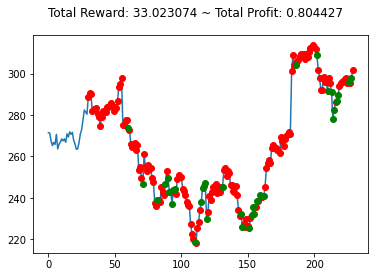

1
4/4 [==============================] - 0s 3ms/step - loss: 6669.6230


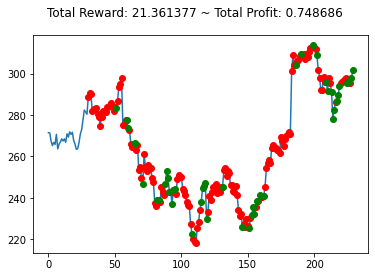

2
4/4 [==============================] - 0s 4ms/step - loss: 4059.0679


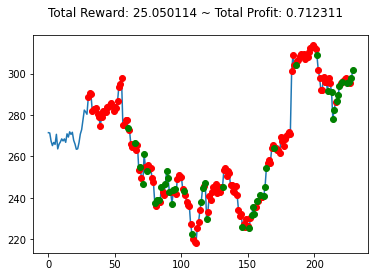

3
4/4 [==============================] - 0s 4ms/step - loss: 2451.2773


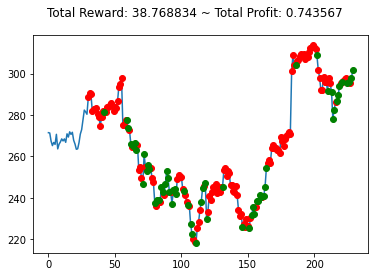

4
4/4 [==============================] - 0s 4ms/step - loss: 1553.7610


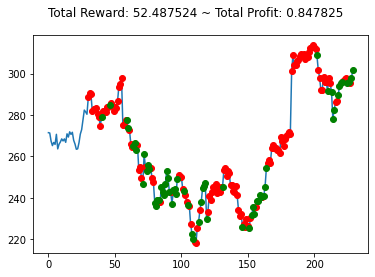

5
4/4 [==============================] - 0s 4ms/step - loss: 1034.2920


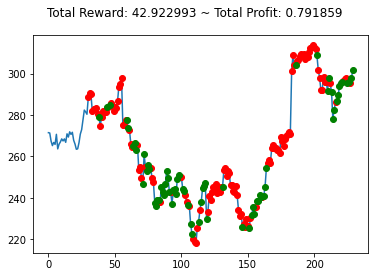

6
4/4 [==============================] - 0s 4ms/step - loss: 619.8192


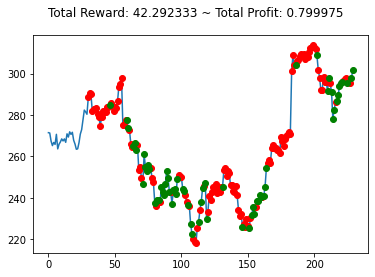

7
4/4 [==============================] - 0s 4ms/step - loss: 431.2867


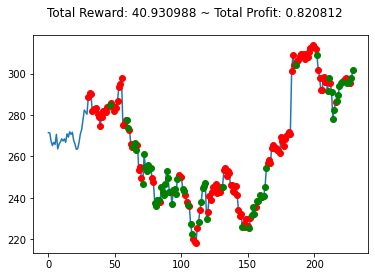

8
4/4 [==============================] - 0s 4ms/step - loss: 280.9939


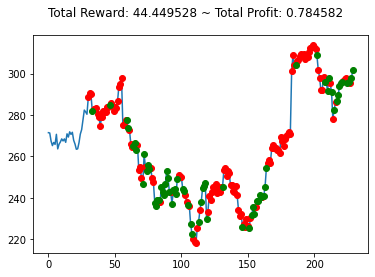

9
4/4 [==============================] - 0s 4ms/step - loss: 182.3004


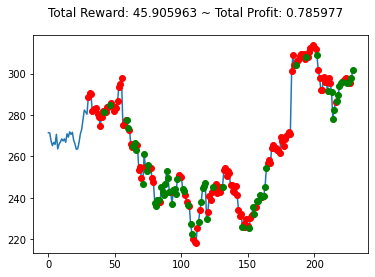

10
4/4 [==============================] - 0s 4ms/step - loss: 122.5146


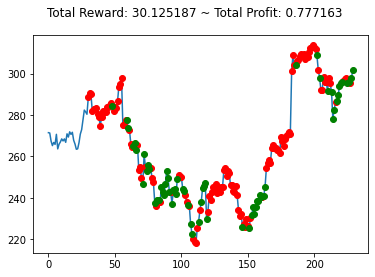

11
4/4 [==============================] - 0s 3ms/step - loss: 98.1951


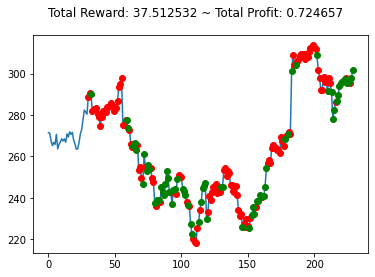

12
4/4 [==============================] - 0s 5ms/step - loss: 83.7369


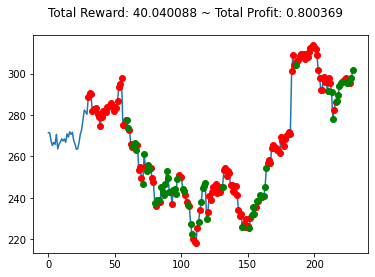

13
4/4 [==============================] - 0s 5ms/step - loss: 82.9065


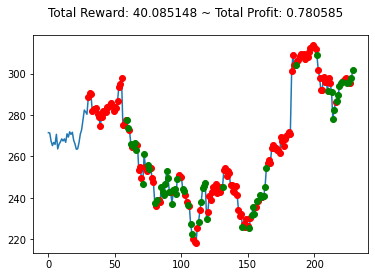

14
4/4 [==============================] - 0s 4ms/step - loss: 79.5746


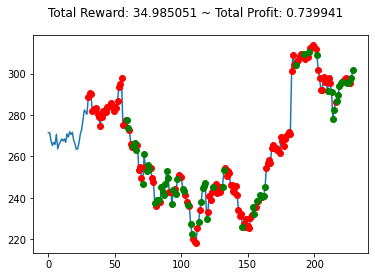

15
4/4 [==============================] - 0s 4ms/step - loss: 80.3628


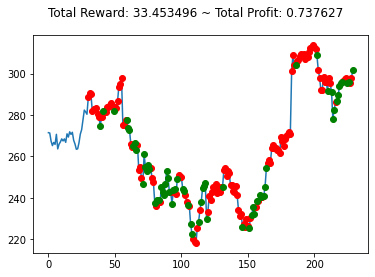

16
4/4 [==============================] - 0s 5ms/step - loss: 82.0373


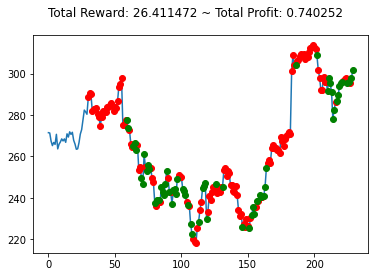

17
4/4 [==============================] - 0s 5ms/step - loss: 83.0127


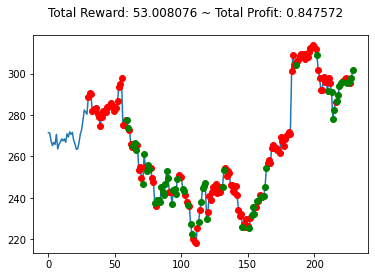

18
4/4 [==============================] - 0s 7ms/step - loss: 78.3627


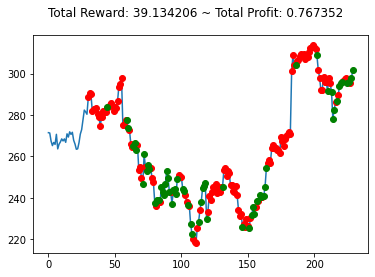

19
4/4 [==============================] - 0s 5ms/step - loss: 76.0221


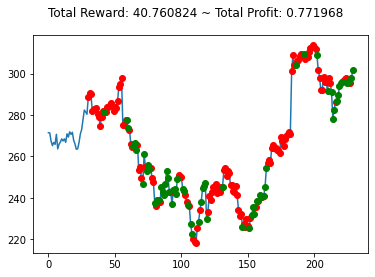

20
4/4 [==============================] - 0s 5ms/step - loss: 74.0657


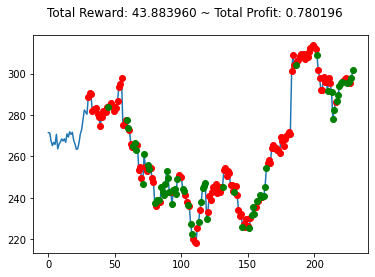

21
4/4 [==============================] - 0s 5ms/step - loss: 73.5809


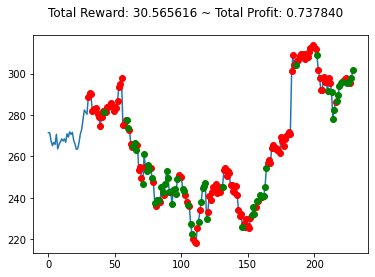

22
4/4 [==============================] - 0s 5ms/step - loss: 73.0829


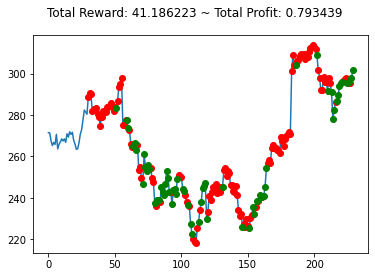

23
4/4 [==============================] - 0s 5ms/step - loss: 69.0661


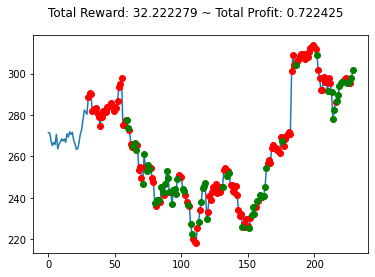

24
4/4 [==============================] - 0s 5ms/step - loss: 73.3145


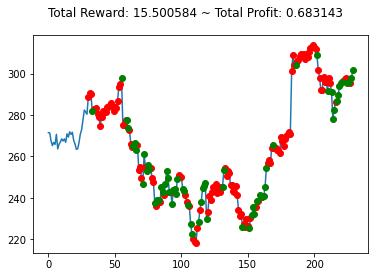

25
4/4 [==============================] - 0s 5ms/step - loss: 70.2478


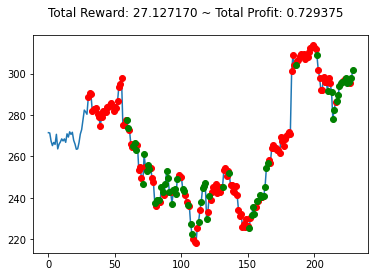

26
4/4 [==============================] - 0s 4ms/step - loss: 68.3885


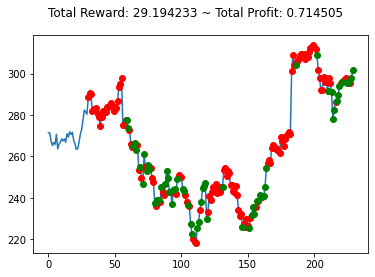

27
4/4 [==============================] - 0s 5ms/step - loss: 64.9315


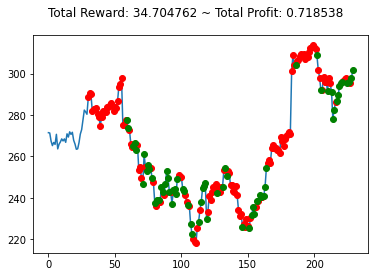

28
4/4 [==============================] - 0s 6ms/step - loss: 61.6486


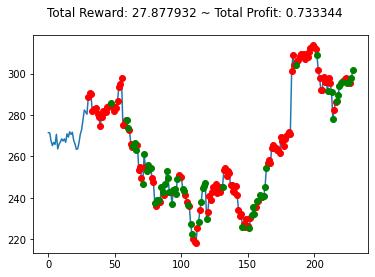

29
4/4 [==============================] - 0s 5ms/step - loss: 61.4972


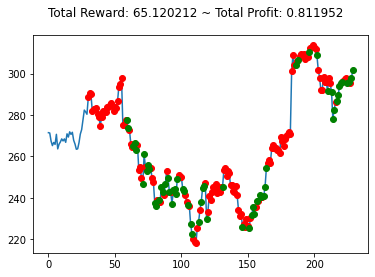

30
4/4 [==============================] - 0s 5ms/step - loss: 59.6543


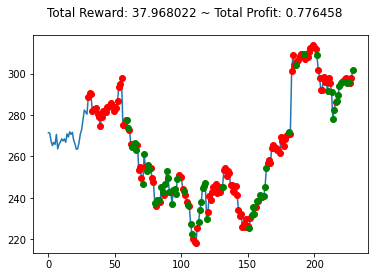

31
4/4 [==============================] - 0s 5ms/step - loss: 58.4790


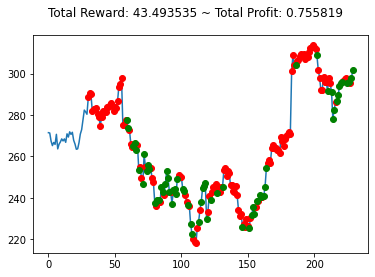

32
4/4 [==============================] - 0s 4ms/step - loss: 60.7897


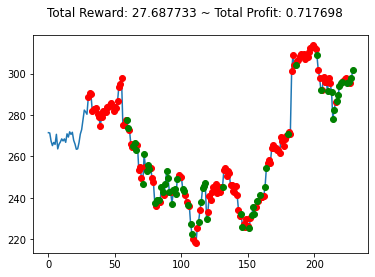

33
4/4 [==============================] - 0s 5ms/step - loss: 59.0688


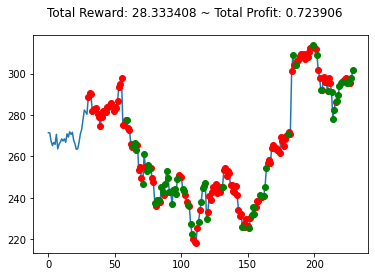

34
4/4 [==============================] - 0s 4ms/step - loss: 53.3551


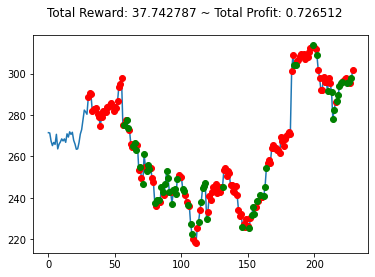

35
4/4 [==============================] - 0s 6ms/step - loss: 50.0164


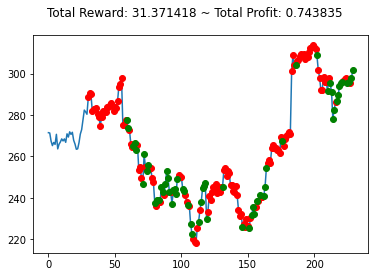

36
4/4 [==============================] - 0s 6ms/step - loss: 48.4182


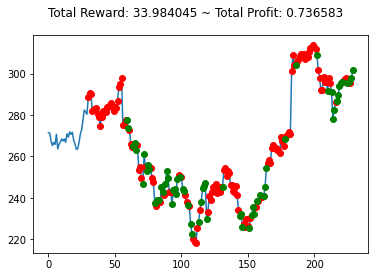

37
4/4 [==============================] - 0s 5ms/step - loss: 45.6597


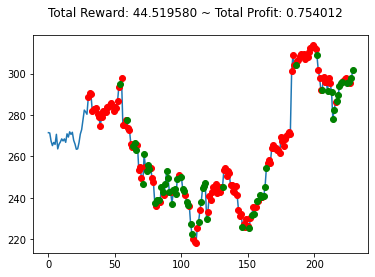

38
4/4 [==============================] - 0s 5ms/step - loss: 41.4074


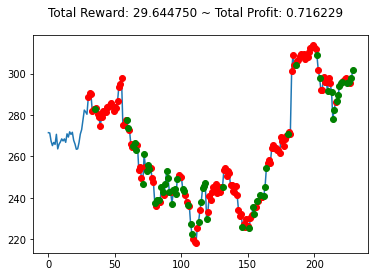

39
4/4 [==============================] - 0s 6ms/step - loss: 38.1621


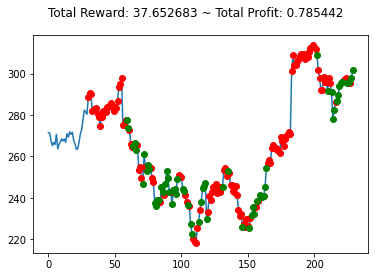

40
4/4 [==============================] - 0s 5ms/step - loss: 35.1870


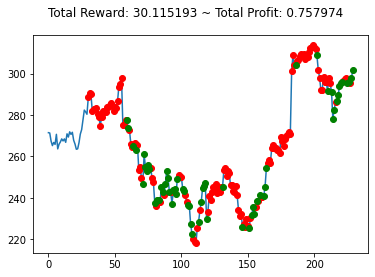

41
4/4 [==============================] - 0s 5ms/step - loss: 26.2452


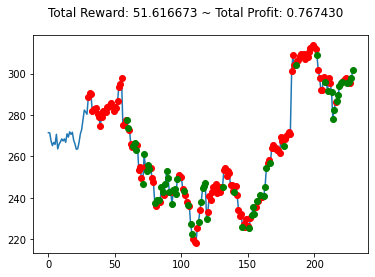

42
4/4 [==============================] - 0s 6ms/step - loss: 24.8159


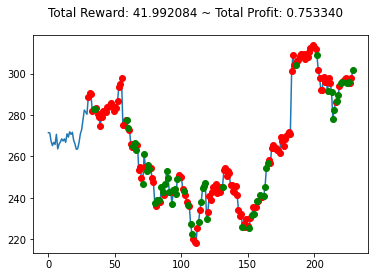

43
4/4 [==============================] - 0s 5ms/step - loss: 23.1218


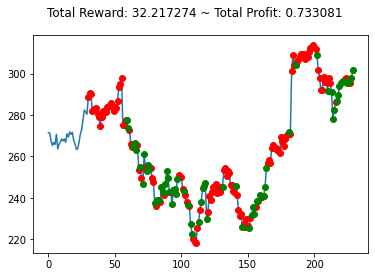

44
4/4 [==============================] - 0s 4ms/step - loss: 23.2209


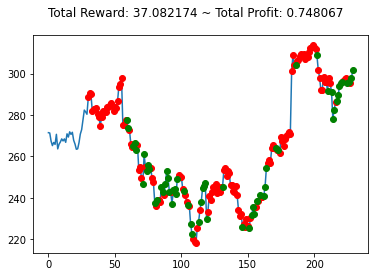

45
4/4 [==============================] - 0s 6ms/step - loss: 23.3880


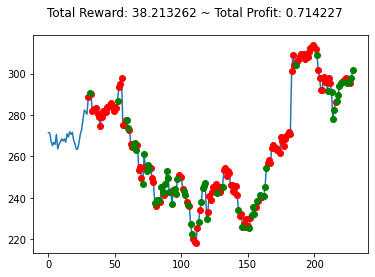

46
4/4 [==============================] - 0s 4ms/step - loss: 22.6488


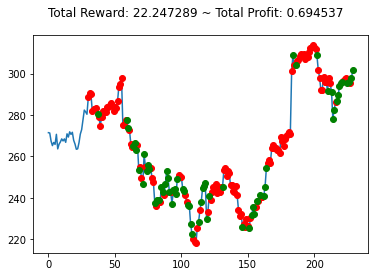

47
4/4 [==============================] - 0s 4ms/step - loss: 22.1858


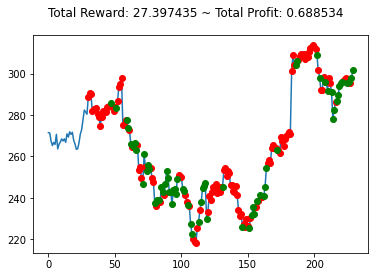

48
4/4 [==============================] - 0s 7ms/step - loss: 22.5947


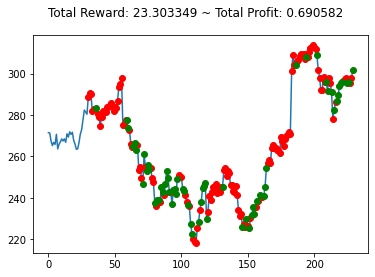

49
4/4 [==============================] - 0s 7ms/step - loss: 22.2924


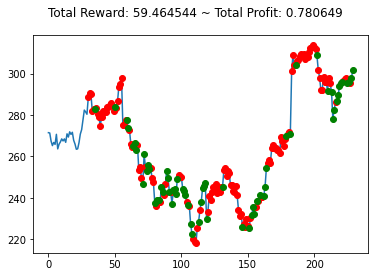

50
4/4 [==============================] - 0s 3ms/step - loss: 22.1151


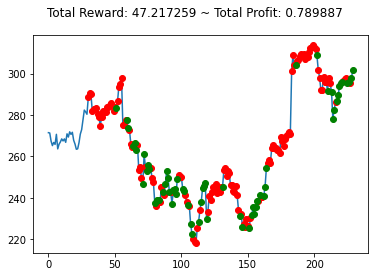

51
4/4 [==============================] - 0s 5ms/step - loss: 22.0685


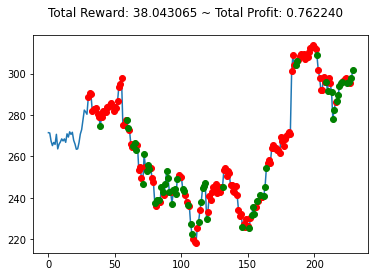

52
4/4 [==============================] - 0s 7ms/step - loss: 21.2331


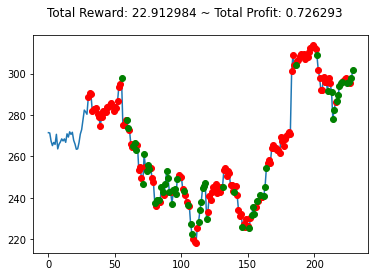

53
4/4 [==============================] - 0s 5ms/step - loss: 21.1433


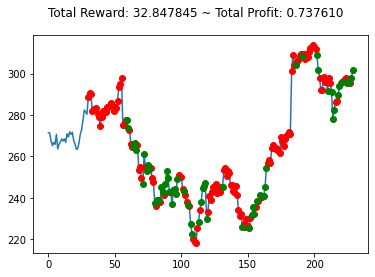

54
4/4 [==============================] - 0s 6ms/step - loss: 21.0720


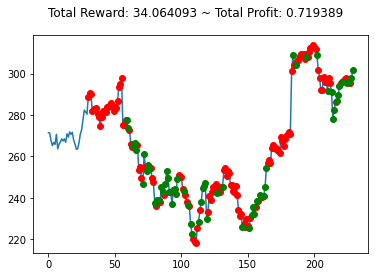

55
4/4 [==============================] - 0s 4ms/step - loss: 21.6251


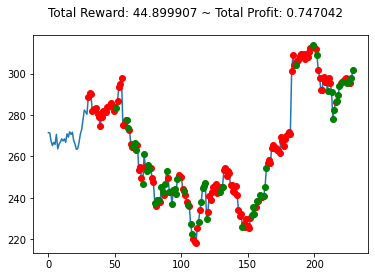

56
4/4 [==============================] - 0s 6ms/step - loss: 21.4347


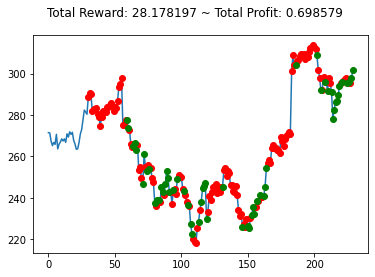

57
4/4 [==============================] - 0s 7ms/step - loss: 20.0292


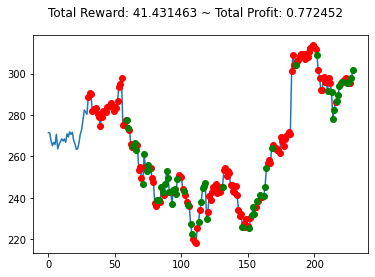

58
4/4 [==============================] - 0s 7ms/step - loss: 19.7902


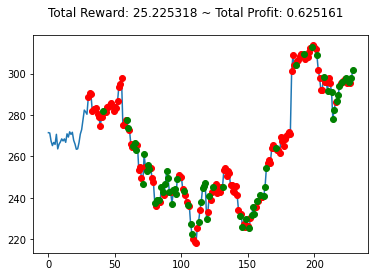

59
4/4 [==============================] - 0s 8ms/step - loss: 19.3723


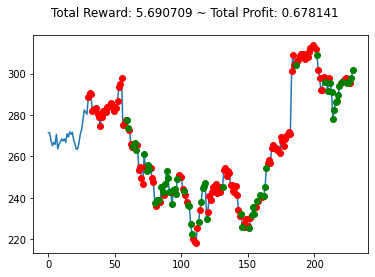

60
4/4 [==============================] - 0s 5ms/step - loss: 19.4634


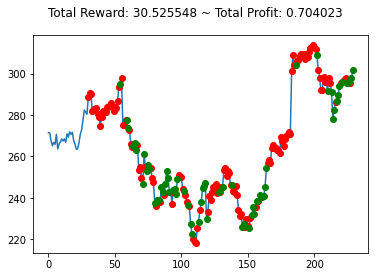

61
4/4 [==============================] - 0s 7ms/step - loss: 19.6114


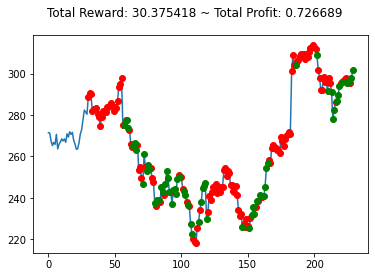

62
4/4 [==============================] - 0s 6ms/step - loss: 19.7075


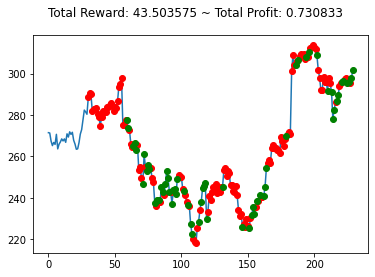

63
4/4 [==============================] - 0s 5ms/step - loss: 19.5290


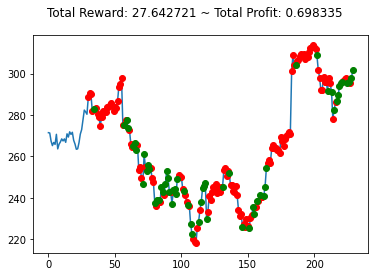

64
4/4 [==============================] - 0s 5ms/step - loss: 19.7121


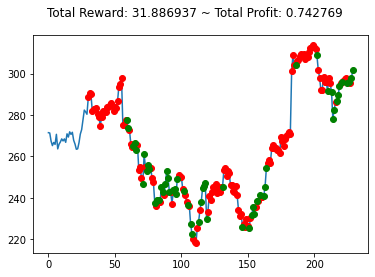

65
4/4 [==============================] - 0s 5ms/step - loss: 19.6956


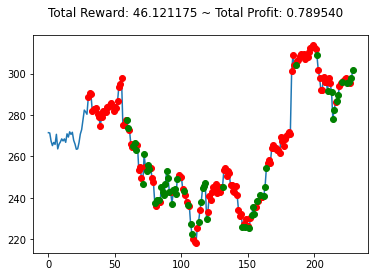

66
4/4 [==============================] - 0s 4ms/step - loss: 18.3896


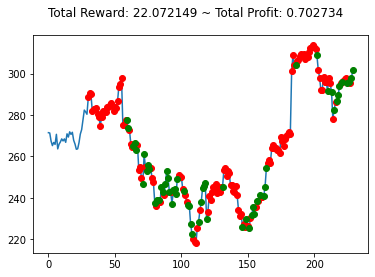

67
4/4 [==============================] - 0s 4ms/step - loss: 18.3727


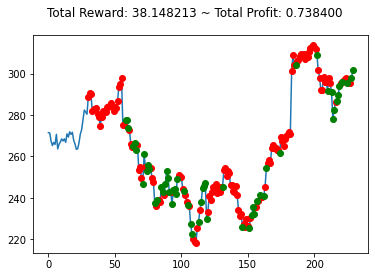

68
4/4 [==============================] - 0s 5ms/step - loss: 18.9820


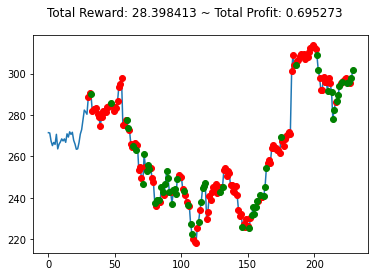

69
4/4 [==============================] - 0s 5ms/step - loss: 18.7523


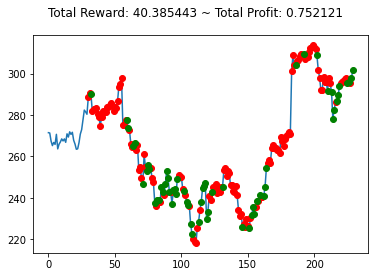

70
4/4 [==============================] - 0s 4ms/step - loss: 18.6336


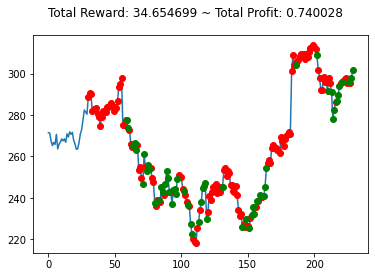

71
4/4 [==============================] - 0s 5ms/step - loss: 18.4961


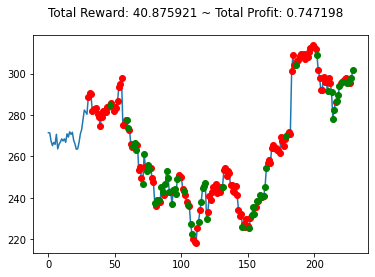

72
4/4 [==============================] - 0s 4ms/step - loss: 18.3598


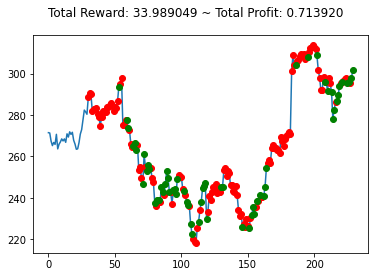

73
4/4 [==============================] - 0s 6ms/step - loss: 17.7141


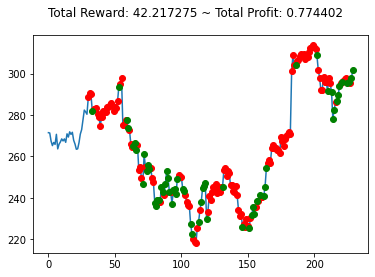

74
4/4 [==============================] - 0s 6ms/step - loss: 19.8606


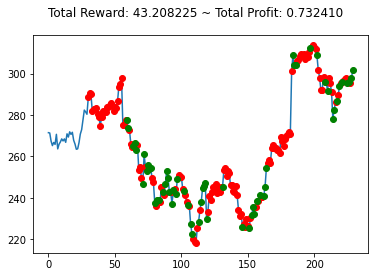

75
4/4 [==============================] - 0s 6ms/step - loss: 18.4075


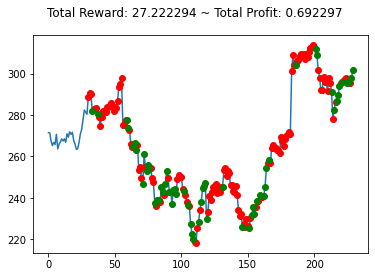

76
4/4 [==============================] - 0s 7ms/step - loss: 18.1589


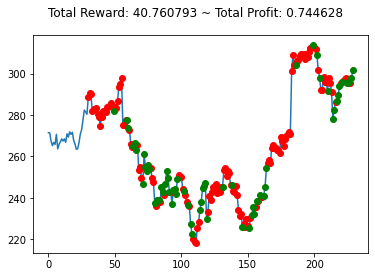

77
4/4 [==============================] - 0s 6ms/step - loss: 19.8786


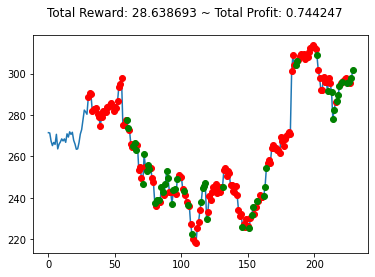

78
4/4 [==============================] - 0s 4ms/step - loss: 19.3372


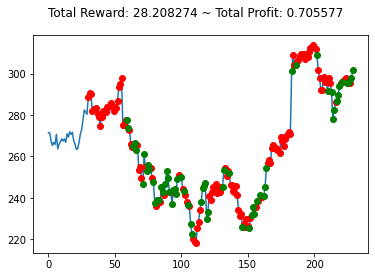

79
4/4 [==============================] - 0s 6ms/step - loss: 18.6997


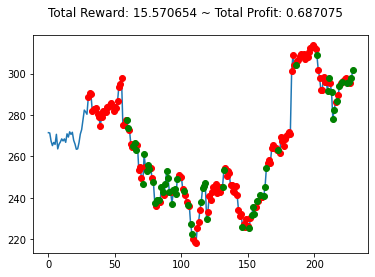

80
4/4 [==============================] - 0s 4ms/step - loss: 18.3837


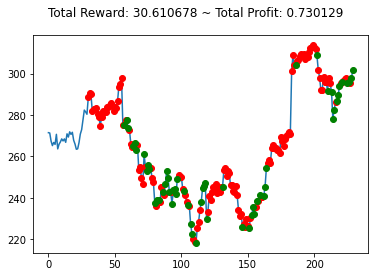

81
4/4 [==============================] - 0s 4ms/step - loss: 18.5282


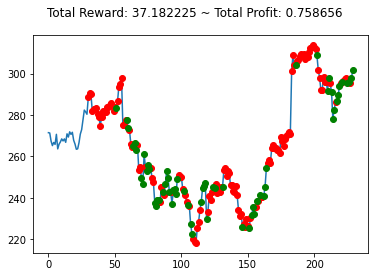

82
4/4 [==============================] - 0s 4ms/step - loss: 19.6121


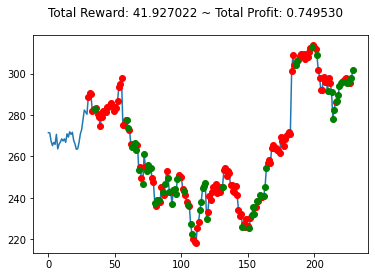

83
4/4 [==============================] - 0s 4ms/step - loss: 19.2115


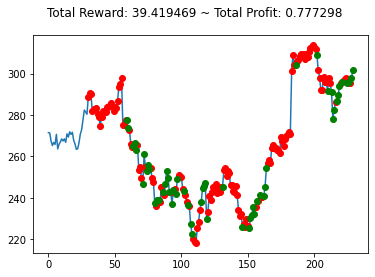

84
4/4 [==============================] - 0s 7ms/step - loss: 18.9400


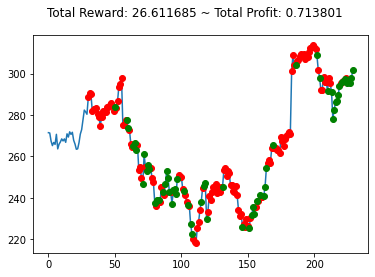

85
4/4 [==============================] - 0s 7ms/step - loss: 18.5382


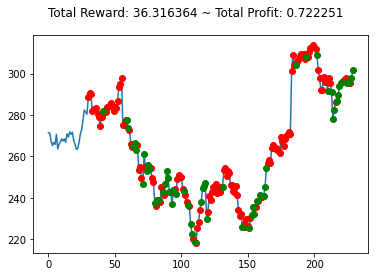

86
4/4 [==============================] - 0s 5ms/step - loss: 18.1872


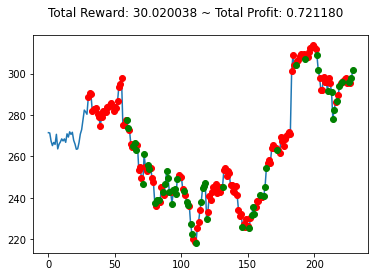

87
4/4 [==============================] - 0s 4ms/step - loss: 17.9348


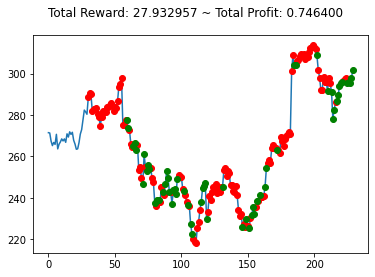

88
4/4 [==============================] - 0s 4ms/step - loss: 17.2733


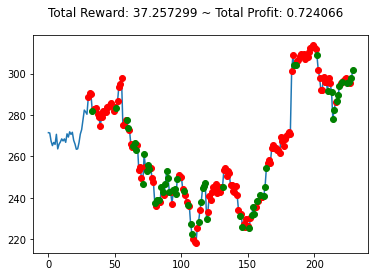

89
4/4 [==============================] - 0s 5ms/step - loss: 17.0895


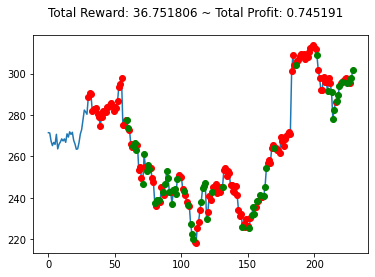

90
4/4 [==============================] - 0s 4ms/step - loss: 16.4052


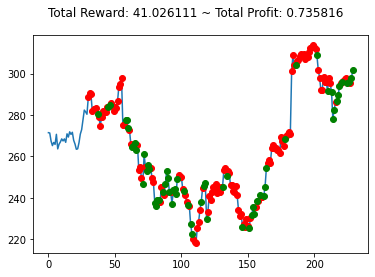

91
4/4 [==============================] - 0s 4ms/step - loss: 16.5616


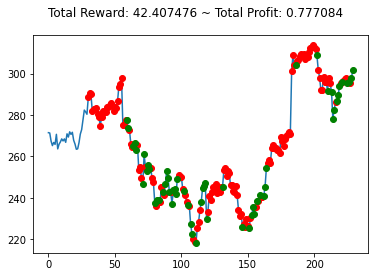

92
4/4 [==============================] - 0s 5ms/step - loss: 17.0245


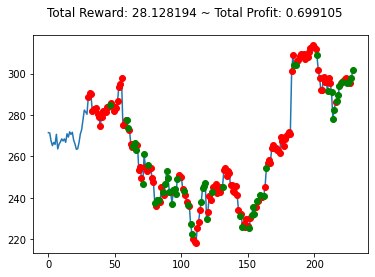

93
4/4 [==============================] - 0s 5ms/step - loss: 16.5467


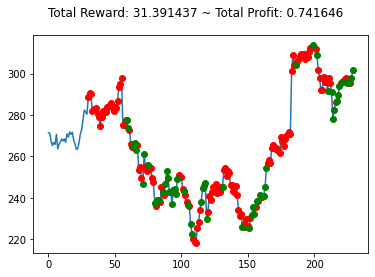

94
4/4 [==============================] - 0s 5ms/step - loss: 16.5061


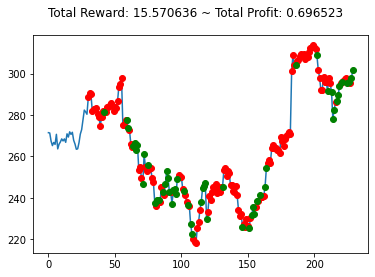

95
4/4 [==============================] - 0s 5ms/step - loss: 16.4938


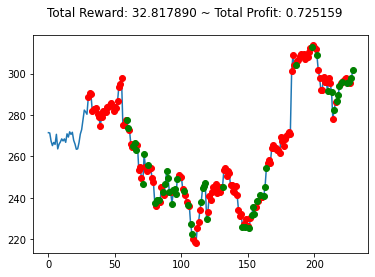

96
4/4 [==============================] - 0s 6ms/step - loss: 16.6645


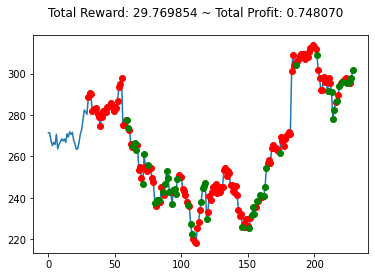

97
4/4 [==============================] - 0s 6ms/step - loss: 16.5077


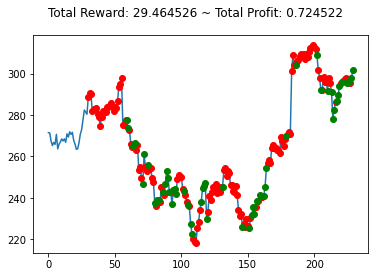

98
4/4 [==============================] - 0s 6ms/step - loss: 15.9733


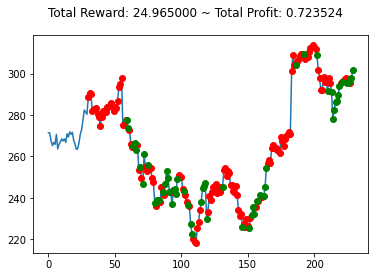

99
4/4 [==============================] - 0s 6ms/step - loss: 15.8366


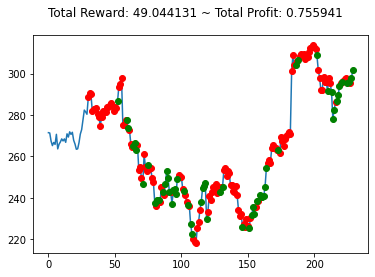

100
4/4 [==============================] - 0s 8ms/step - loss: 15.8124


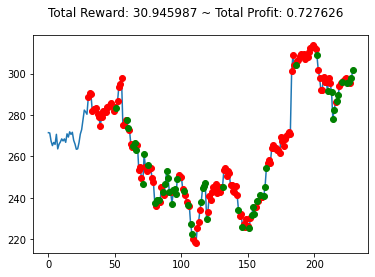

101
4/4 [==============================] - 0s 6ms/step - loss: 15.5062


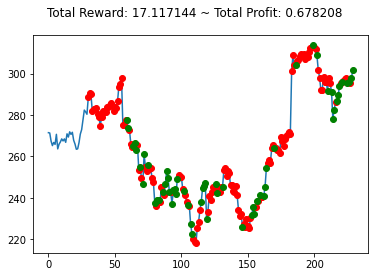

102
4/4 [==============================] - 0s 7ms/step - loss: 15.3703


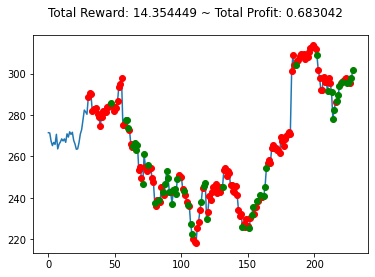

103
4/4 [==============================] - 0s 6ms/step - loss: 15.4062


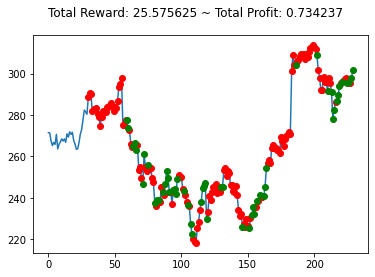

104
4/4 [==============================] - 0s 6ms/step - loss: 15.3187


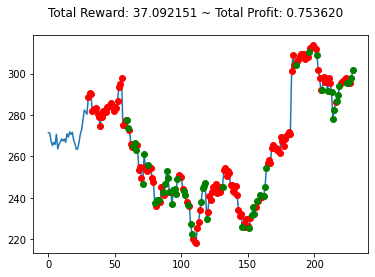

105
4/4 [==============================] - 0s 4ms/step - loss: 15.2509


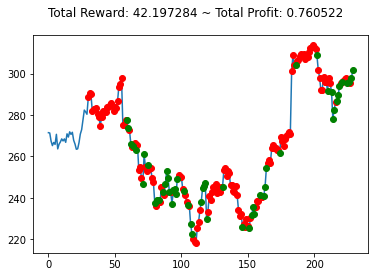

106
4/4 [==============================] - 0s 8ms/step - loss: 15.3107


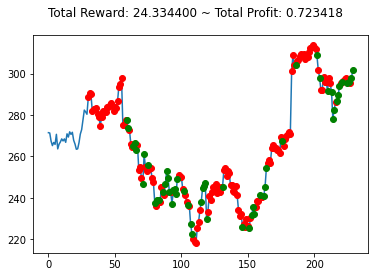

107
4/4 [==============================] - 0s 7ms/step - loss: 14.9681


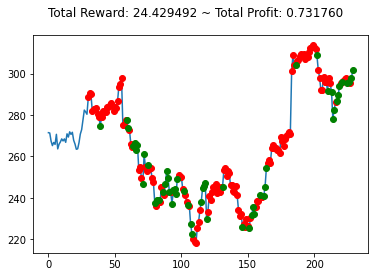

108
4/4 [==============================] - 0s 4ms/step - loss: 14.6726


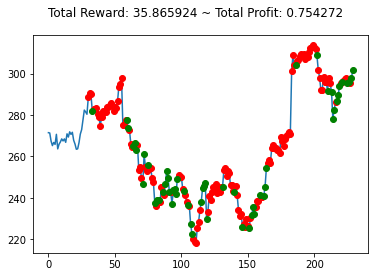

109
4/4 [==============================] - 0s 6ms/step - loss: 14.6774


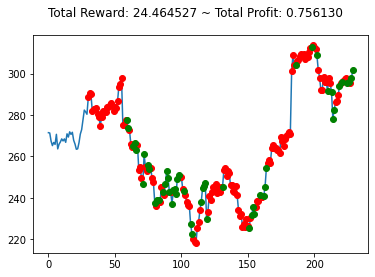

110
4/4 [==============================] - 0s 3ms/step - loss: 14.5925


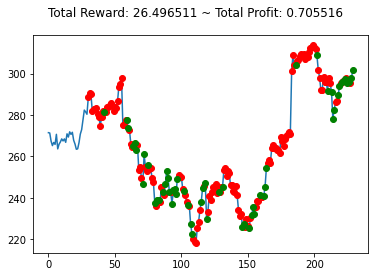

111
4/4 [==============================] - 0s 4ms/step - loss: 14.7446


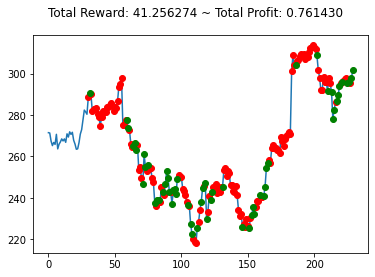

112
4/4 [==============================] - 0s 7ms/step - loss: 14.5803


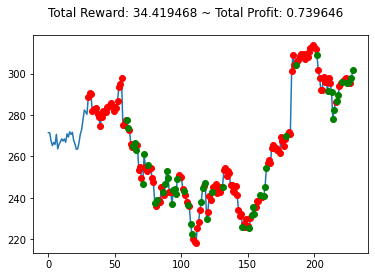

113
4/4 [==============================] - 0s 6ms/step - loss: 14.5643


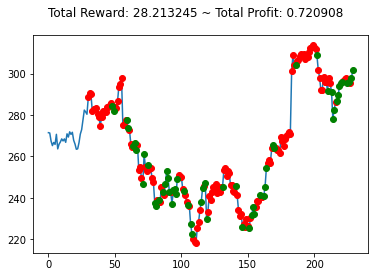

114
4/4 [==============================] - 0s 4ms/step - loss: 14.4132


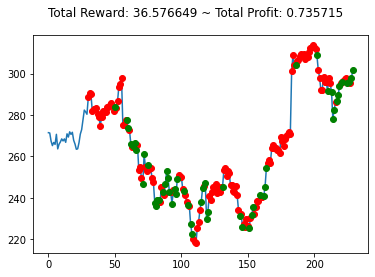

115
4/4 [==============================] - 0s 4ms/step - loss: 14.3597


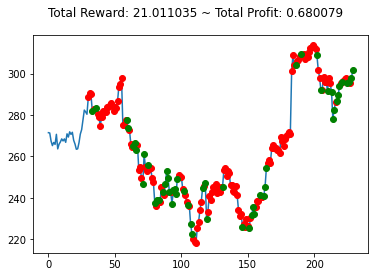

116
4/4 [==============================] - 0s 7ms/step - loss: 14.2499


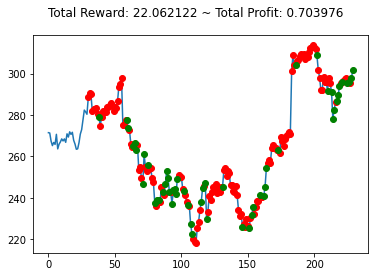

117
4/4 [==============================] - 0s 6ms/step - loss: 14.3037


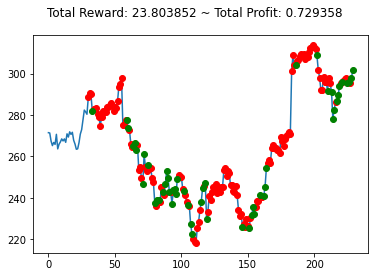

118
4/4 [==============================] - 0s 9ms/step - loss: 13.9270


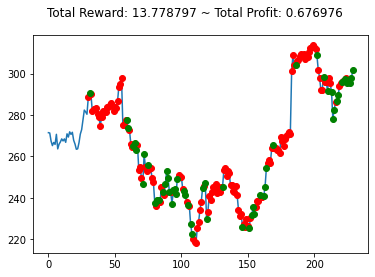

119
4/4 [==============================] - 0s 6ms/step - loss: 13.5555


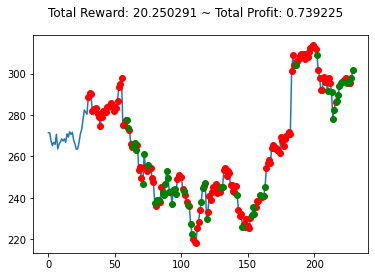

120
4/4 [==============================] - 0s 6ms/step - loss: 13.4871


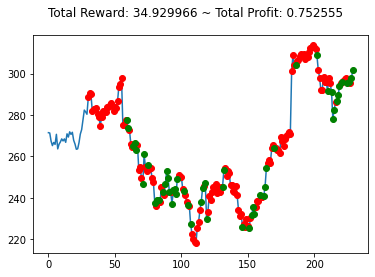

121
4/4 [==============================] - 0s 8ms/step - loss: 13.3572


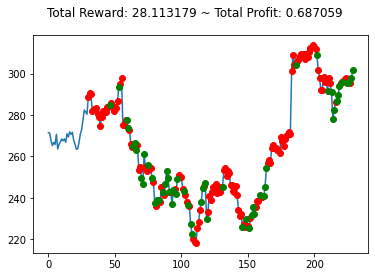

122
4/4 [==============================] - 0s 6ms/step - loss: 13.1768


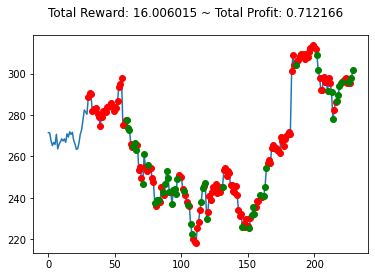

123
4/4 [==============================] - 0s 4ms/step - loss: 13.1251


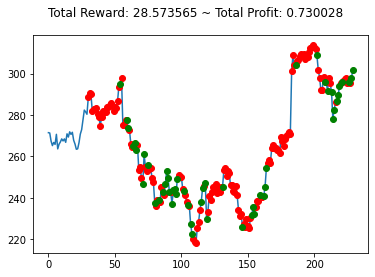

124
4/4 [==============================] - 0s 8ms/step - loss: 13.0360


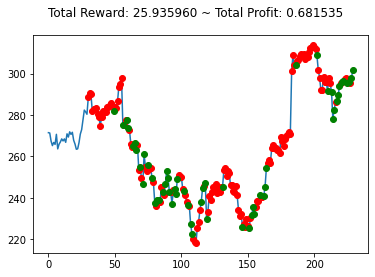

125
4/4 [==============================] - 0s 8ms/step - loss: 12.5401


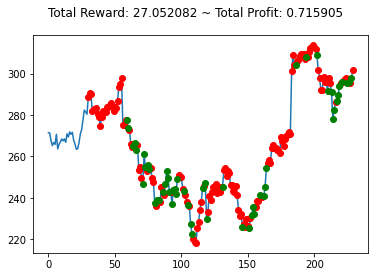

126
4/4 [==============================] - 0s 4ms/step - loss: 12.3123


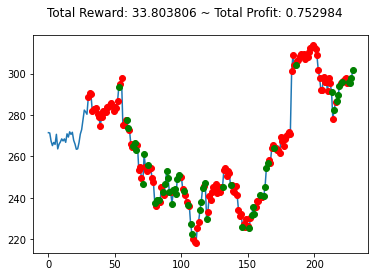

127
4/4 [==============================] - 0s 6ms/step - loss: 12.4633


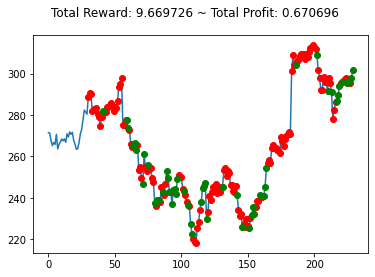

128
4/4 [==============================] - 0s 5ms/step - loss: 12.2860


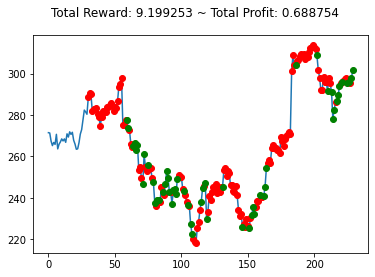

129
4/4 [==============================] - 0s 7ms/step - loss: 12.6596


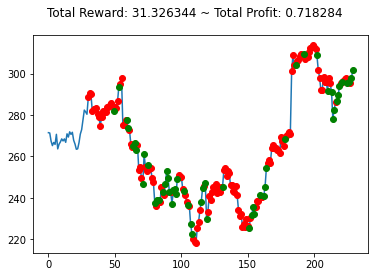

130
4/4 [==============================] - 0s 7ms/step - loss: 12.5096


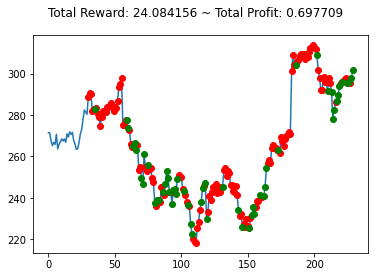

131
4/4 [==============================] - 0s 5ms/step - loss: 12.3760


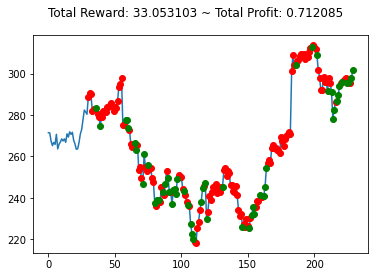

132
4/4 [==============================] - 0s 5ms/step - loss: 12.2629


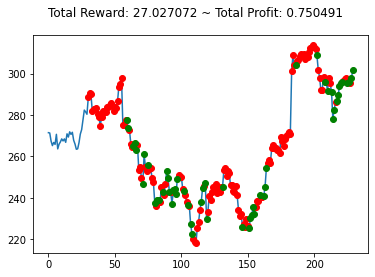

133
4/4 [==============================] - 0s 6ms/step - loss: 12.2573


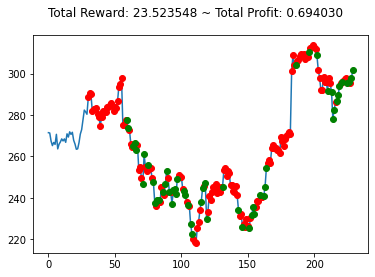

134
4/4 [==============================] - 0s 5ms/step - loss: 12.1584


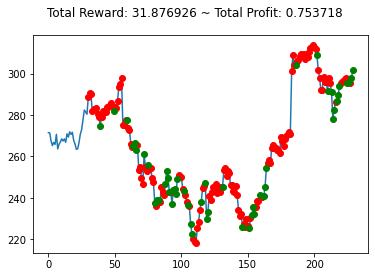

135
4/4 [==============================] - 0s 5ms/step - loss: 12.0928


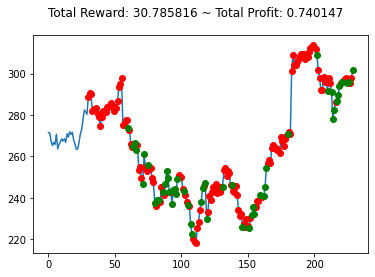

136
4/4 [==============================] - 0s 4ms/step - loss: 12.1283


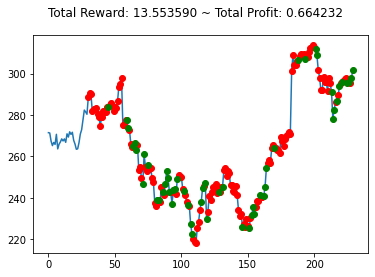

137
4/4 [==============================] - 0s 6ms/step - loss: 11.8279


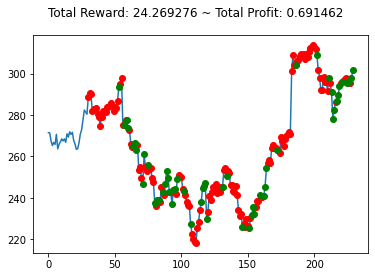

138
4/4 [==============================] - 0s 7ms/step - loss: 11.6700


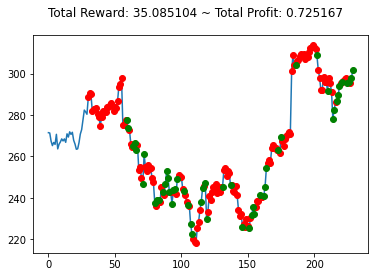

139
4/4 [==============================] - 0s 4ms/step - loss: 11.7222


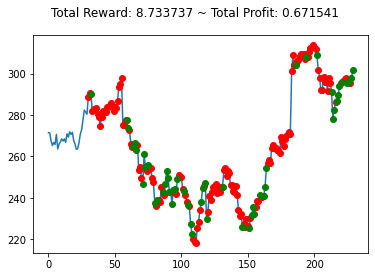

140
4/4 [==============================] - 0s 7ms/step - loss: 11.3583


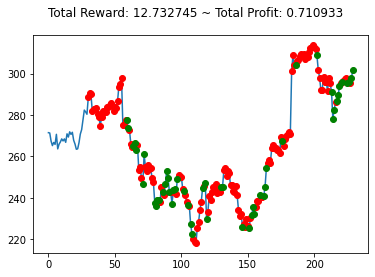

141
4/4 [==============================] - 0s 5ms/step - loss: 11.2591


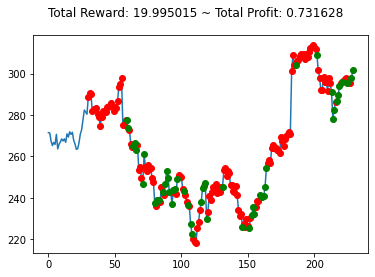

142
4/4 [==============================] - 0s 8ms/step - loss: 11.2662


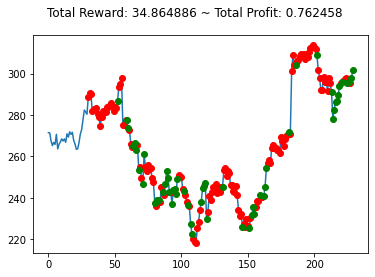

143
4/4 [==============================] - 0s 6ms/step - loss: 11.1466


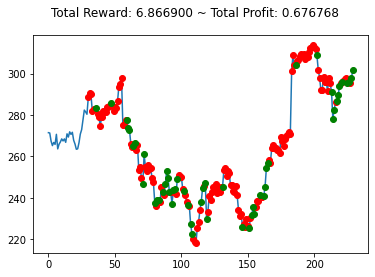

144
4/4 [==============================] - 0s 8ms/step - loss: 11.1128


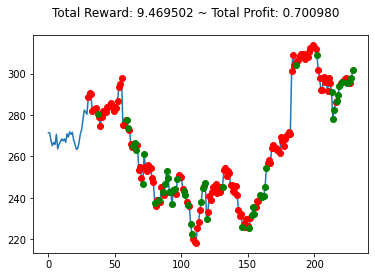

145
4/4 [==============================] - 0s 10ms/step - loss: 11.3144


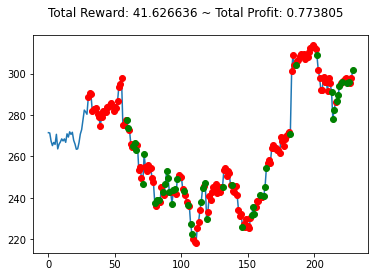

146
4/4 [==============================] - 0s 6ms/step - loss: 11.2692


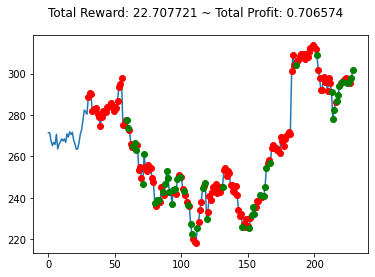

147
4/4 [==============================] - 0s 6ms/step - loss: 11.2330


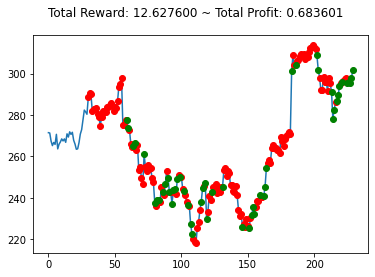

148
4/4 [==============================] - 0s 7ms/step - loss: 12.2420


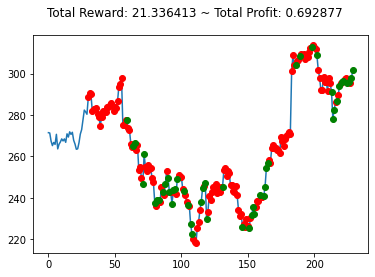

149
4/4 [==============================] - 0s 4ms/step - loss: 12.2862


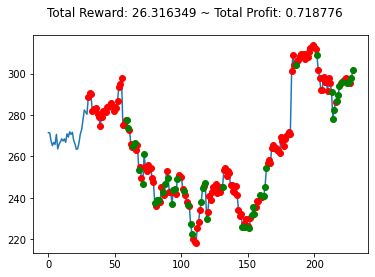

150
4/4 [==============================] - 0s 5ms/step - loss: 12.0600


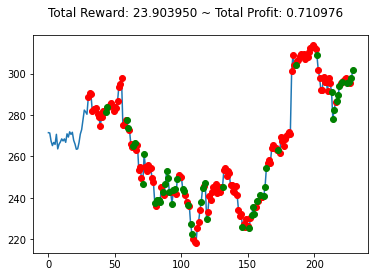

151
4/4 [==============================] - 0s 6ms/step - loss: 12.0479


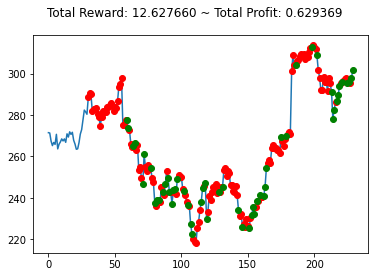

152
4/4 [==============================] - 0s 6ms/step - loss: 12.0233


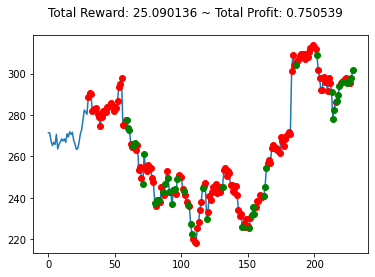

153
4/4 [==============================] - 0s 6ms/step - loss: 11.9613


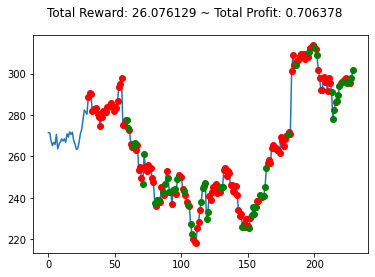

154
4/4 [==============================] - 0s 7ms/step - loss: 12.0191


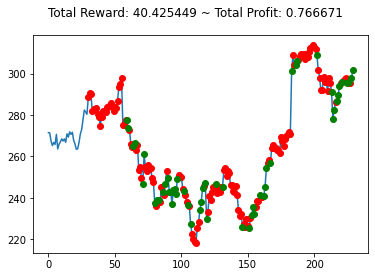

155
4/4 [==============================] - 0s 5ms/step - loss: 11.9408


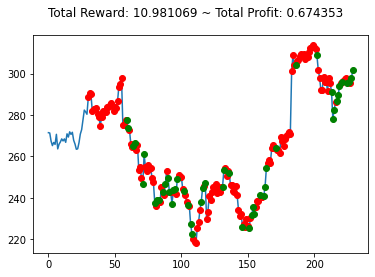

156
4/4 [==============================] - 0s 5ms/step - loss: 11.8454


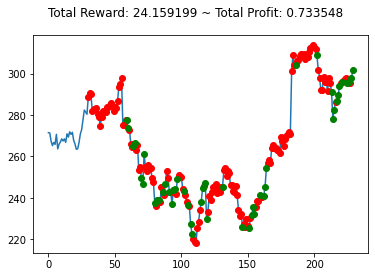

157
4/4 [==============================] - 0s 7ms/step - loss: 11.8161


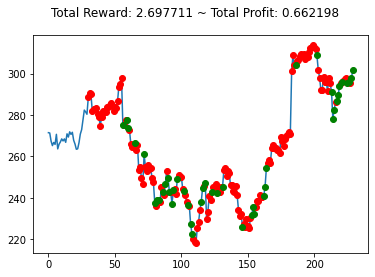

158
4/4 [==============================] - 0s 4ms/step - loss: 11.8183


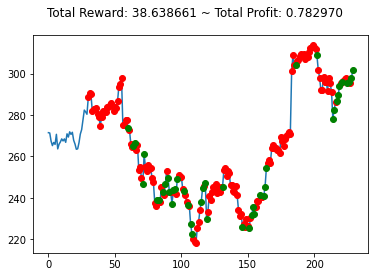

159
4/4 [==============================] - 0s 5ms/step - loss: 11.7729


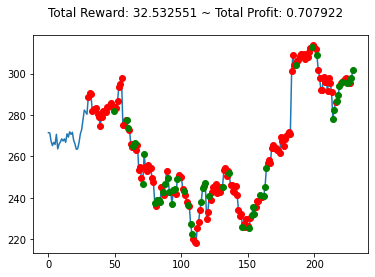

160
4/4 [==============================] - 0s 8ms/step - loss: 11.6969


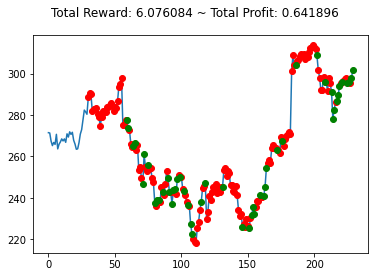

161
4/4 [==============================] - 0s 6ms/step - loss: 11.6204


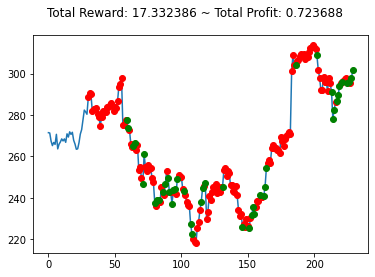

162
4/4 [==============================] - 0s 7ms/step - loss: 11.5474


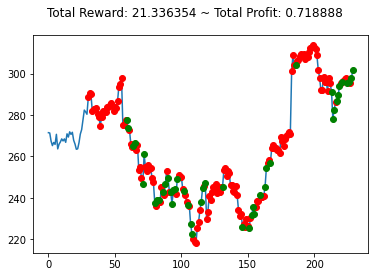

163
4/4 [==============================] - 0s 4ms/step - loss: 12.7700


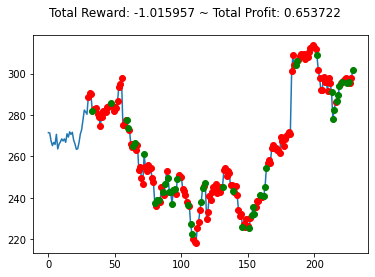

164
4/4 [==============================] - 0s 3ms/step - loss: 15.6559


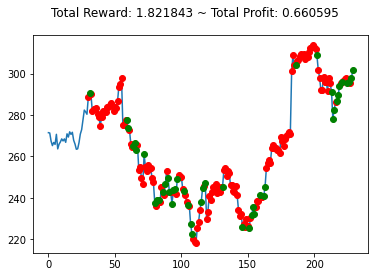

165
4/4 [==============================] - 0s 7ms/step - loss: 15.1746


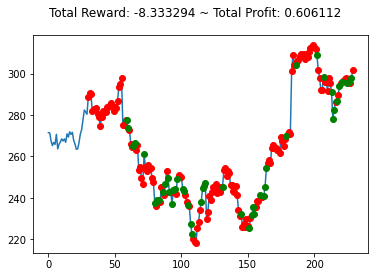

166
4/4 [==============================] - 0s 6ms/step - loss: 15.7355


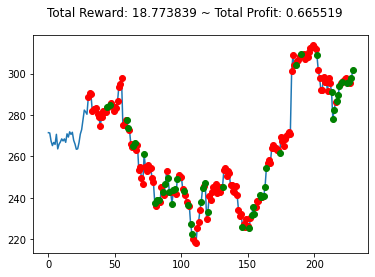

167
4/4 [==============================] - 0s 5ms/step - loss: 15.8327


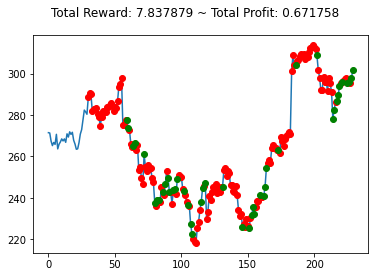

168
4/4 [==============================] - 0s 4ms/step - loss: 15.4660


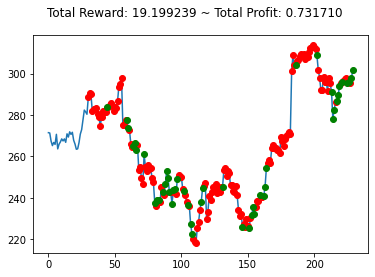

169
4/4 [==============================] - 0s 6ms/step - loss: 15.1627


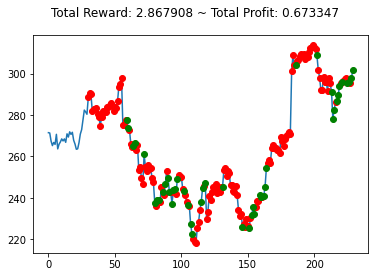

170
4/4 [==============================] - 0s 5ms/step - loss: 14.8123


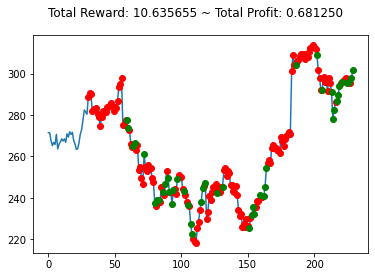

171
4/4 [==============================] - 0s 6ms/step - loss: 14.6455


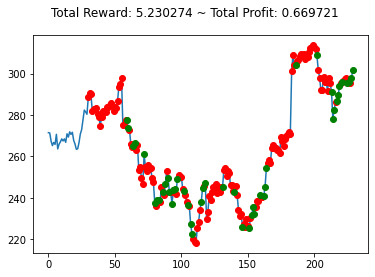

172
4/4 [==============================] - 0s 7ms/step - loss: 14.5089


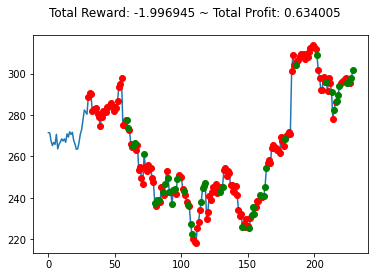

173
4/4 [==============================] - 0s 3ms/step - loss: 14.3567


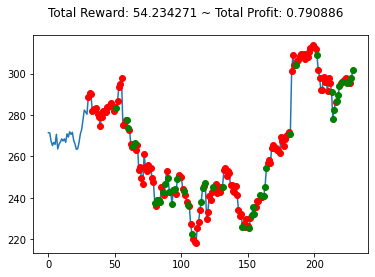

174
4/4 [==============================] - 0s 4ms/step - loss: 14.2211


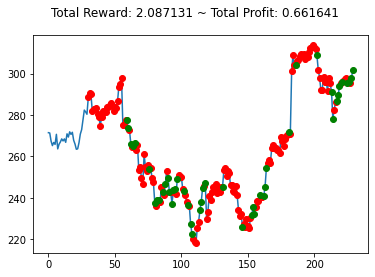

175
4/4 [==============================] - 0s 5ms/step - loss: 14.3049


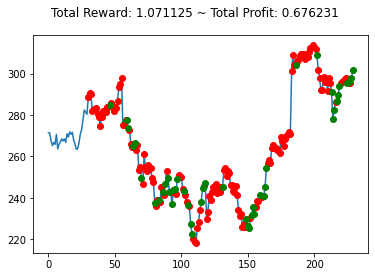

176
4/4 [==============================] - 0s 5ms/step - loss: 13.9232


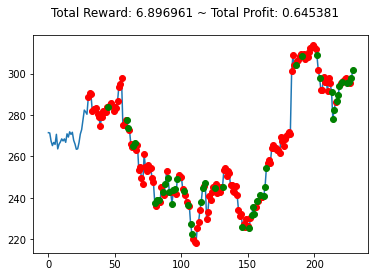

177
4/4 [==============================] - 0s 5ms/step - loss: 13.4699


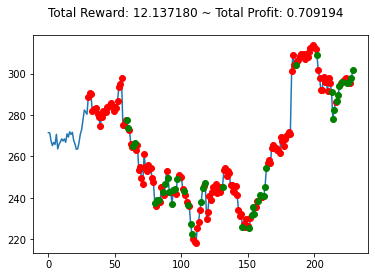

178
4/4 [==============================] - 0s 4ms/step - loss: 13.4578


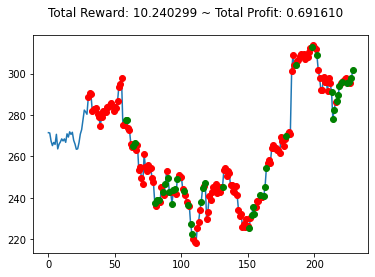

179
4/4 [==============================] - 0s 7ms/step - loss: 13.2276


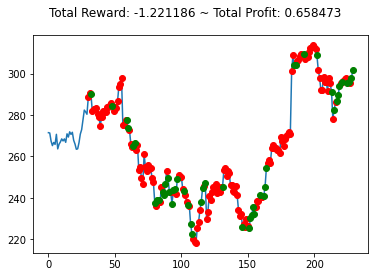

180
4/4 [==============================] - 0s 7ms/step - loss: 13.0286


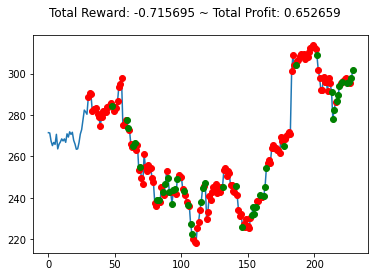

181
4/4 [==============================] - 0s 7ms/step - loss: 12.6588


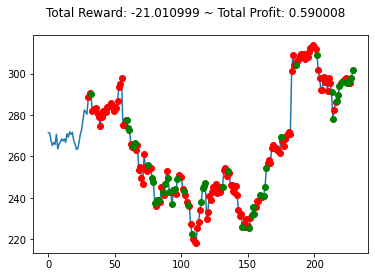

182
4/4 [==============================] - 0s 7ms/step - loss: 12.2504


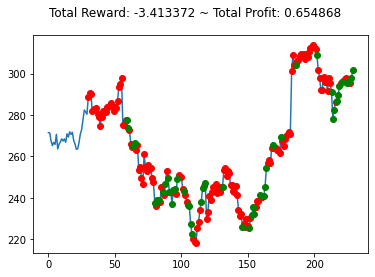

183
4/4 [==============================] - 0s 5ms/step - loss: 12.3755


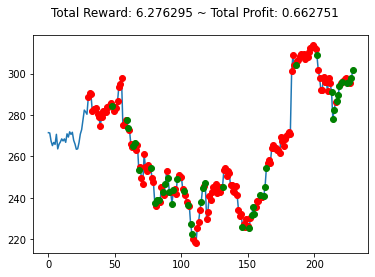

184
4/4 [==============================] - 0s 3ms/step - loss: 12.3927


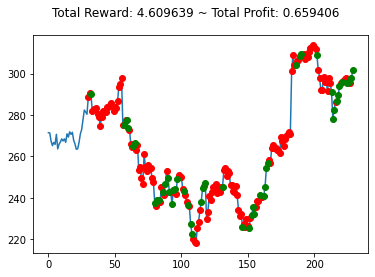

185
4/4 [==============================] - 0s 4ms/step - loss: 12.2597


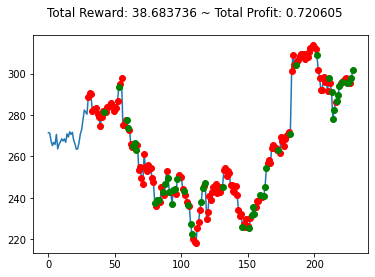

186
4/4 [==============================] - 0s 4ms/step - loss: 12.1305


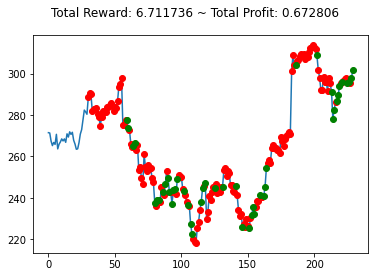

187
4/4 [==============================] - 0s 5ms/step - loss: 12.0339


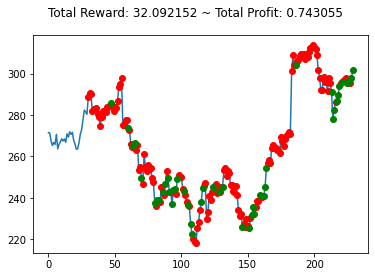

188
4/4 [==============================] - 0s 4ms/step - loss: 11.9889


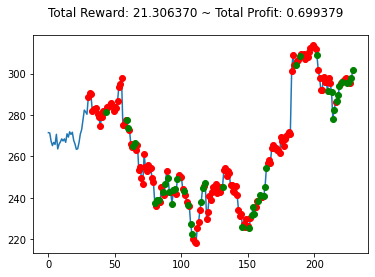

189
4/4 [==============================] - 0s 7ms/step - loss: 12.0546


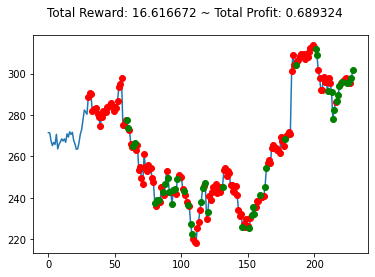

190
4/4 [==============================] - 0s 4ms/step - loss: 11.9537


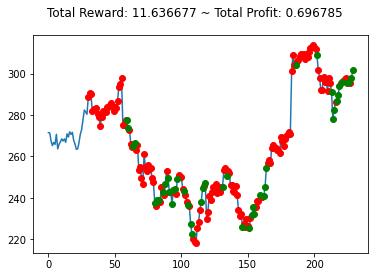

191
4/4 [==============================] - 0s 4ms/step - loss: 11.8014


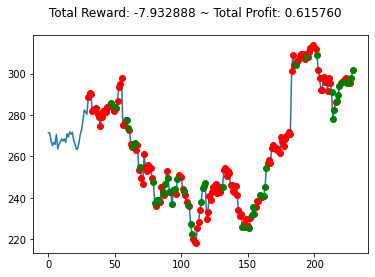

192
4/4 [==============================] - 0s 4ms/step - loss: 11.9833


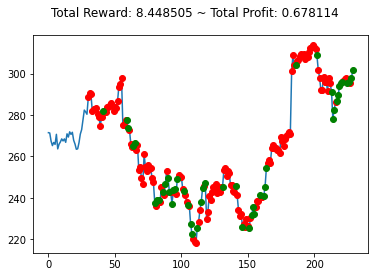

193
4/4 [==============================] - 0s 5ms/step - loss: 11.6487


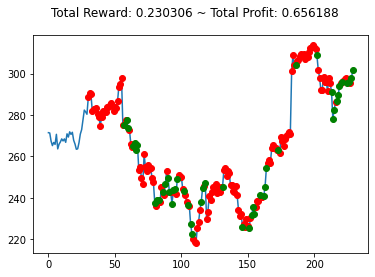

194
4/4 [==============================] - 0s 4ms/step - loss: 12.1539


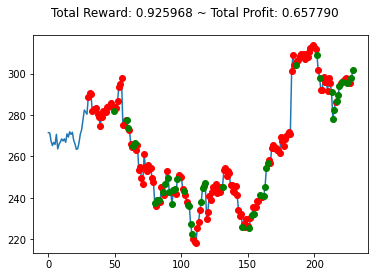

195
4/4 [==============================] - 0s 5ms/step - loss: 12.1083


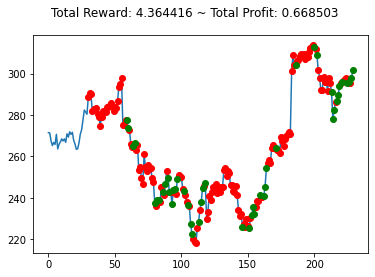

196
4/4 [==============================] - 0s 4ms/step - loss: 11.9886


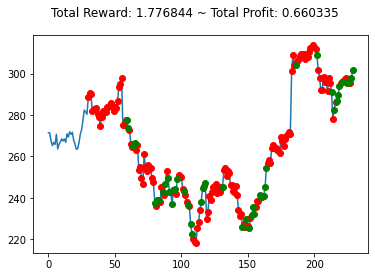

197
4/4 [==============================] - 0s 4ms/step - loss: 10.9109


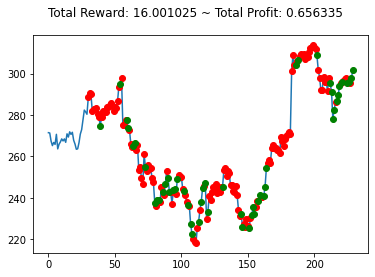

198
4/4 [==============================] - 0s 4ms/step - loss: 10.7625


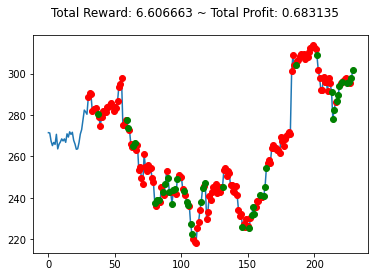

199
4/4 [==============================] - 0s 4ms/step - loss: 10.7097


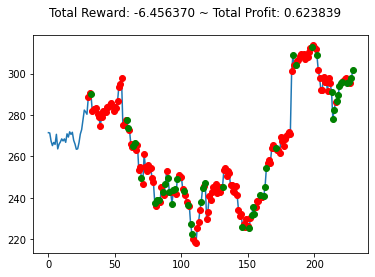

INFO:tensorflow:Assets written to: /content/DQN_model/assets


In [ ]:
agent = train_model()

# DQN Result 

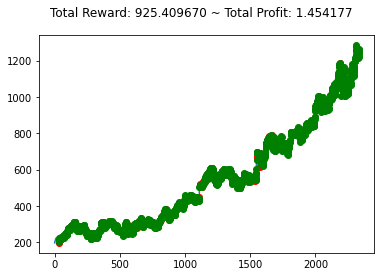

In [ ]:
env = gym.make('stocks-v0',window_size=30)
done = False
state = env.reset()
while not done:

    min_max_scaler = preprocessing.MinMaxScaler()
    norm_stsate = min_max_scaler.fit_transform(state)
    flatten_norm_state = np.ndarray.flatten(norm_stsate)
    action = agent.policy(flatten_norm_state)
    state, reward, done, info = env.step(action)
env.render_all()


# A2C Result

In [ ]:
!pip install stable-baselines3

     |████████████████████████████████| 177 kB 14.1 MB/s 
     |████████████████████████████████| 1.5 MB 62.1 MB/s 
  Created wheel for gym: filename=gym-0.21.0-py3-none-any.whl size=1616825 sha256=3d6eee317cd22980f5e4715e568807f681de5593e90381e54ae4570dd1dddbf6
  Stored in directory: /root/.cache/pip/wheels/76/ee/9c/36bfe3e079df99acf5ae57f4e3464ff2771b34447d6d2f2148
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.17.3
    Uninstalling gym-0.17.3:
      Successfully uninstalled gym-0.17.3


In [ ]:
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env.base_vec_env import VecEnv, VecEnvStepReturn, VecEnvWrapper

In [ ]:
env_maker = lambda: gym.make('stocks-v0', df=STOCKS_GOOGL, frame_bound=(200,1200), window_size=30)
env = DummyVecEnv([env_maker])

In [ ]:
model = A2C('MlpPolicy', env, verbose=1) 
model.learn(total_timesteps=200000)


Streaming output truncated to the last 5000 lines.
|    value_loss         | 15.7      |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 1040     |
|    iterations         | 4400     |
|    time_elapsed       | 21       |
|    total_timesteps    | 22000    |
| train/                |          |
|    entropy_loss       | -0.686   |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 4399     |
|    policy_loss        | 1.31     |
|    value_loss         | 4.26     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 1041     |
|    iterations         | 4500     |
|    time_elapsed       | 21       |
|    total_timesteps    | 22500    |
| train/                |          |
|    entropy_loss       | -0.69    |
|    explained_variance | 0        |
|    learning_rate    

info {'total_reward': 180.73180000000008, 'total_profit': 0.04484229759127719, 'position': 0}


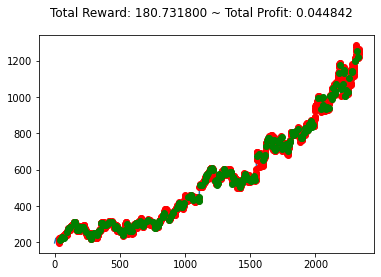

In [ ]:
env = gym.make('stocks-v0', df=STOCKS_GOOGL, window_size=30)
obs = env.reset()
while True: 
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break
plt.cla()
env.render_all()
plt.show()

# **Experiment 2**

### Frame_Bound 1

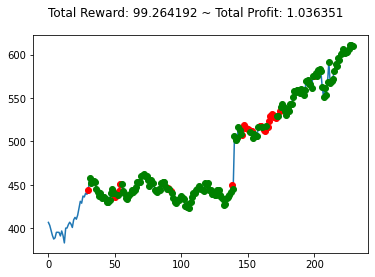

In [ ]:

env = gym.make('stocks-v0',frame_bound = (1000,1200),window_size=30)
done = False
state = env.reset()
while not done:

    min_max_scaler = preprocessing.MinMaxScaler()
    norm_stsate = min_max_scaler.fit_transform(state)
    flatten_norm_state = np.ndarray.flatten(norm_stsate)
    action = agent.policy(flatten_norm_state)
    state, reward, done, info = env.step(action)
env.render_all()

### Frame_Bound 2

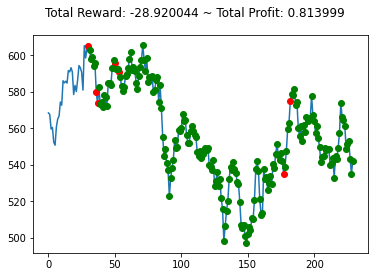

In [ ]:
env = gym.make('stocks-v0',frame_bound = (1300,1500),window_size=30)
done = False
state = env.reset()
while not done:

    min_max_scaler = preprocessing.MinMaxScaler()
    norm_stsate = min_max_scaler.fit_transform(state)
    flatten_norm_state = np.ndarray.flatten(norm_stsate)
    action = agent.policy(flatten_norm_state)
    state, reward, done, info = env.step(action)
env.render_all()

### Frame_Bound 3

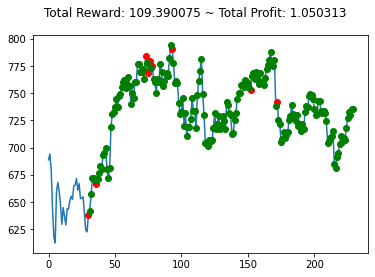

In [ ]:
env = gym.make('stocks-v0',frame_bound = (1600,1800),window_size=30)
done = False
state = env.reset()
while not done:

    min_max_scaler = preprocessing.MinMaxScaler()
    norm_stsate = min_max_scaler.fit_transform(state)
    flatten_norm_state = np.ndarray.flatten(norm_stsate)
    action = agent.policy(flatten_norm_state)
    state, reward, done, info = env.step(action)
env.render_all()

### Frame_Bound 4

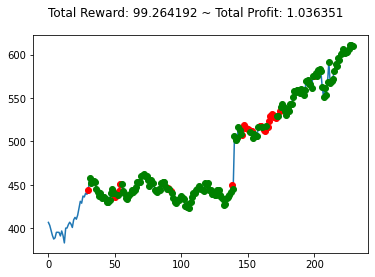

In [ ]:
env = gym.make('stocks-v0',frame_bound = (1000,1200),window_size=30)
done = False
state = env.reset()
while not done:

    min_max_scaler = preprocessing.MinMaxScaler()
    norm_stsate = min_max_scaler.fit_transform(state)
    flatten_norm_state = np.ndarray.flatten(norm_stsate)
    action = agent.policy(flatten_norm_state)
    state, reward, done, info = env.step(action)
env.render_all()

# **Experiment 3**

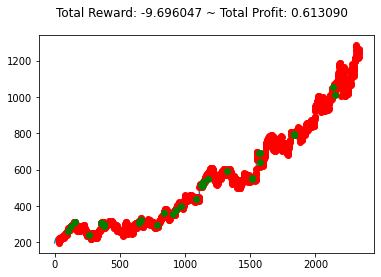

In [ ]:
env = gym.make('stocks-v0',window_size=30)
done = False
state = env.reset()
while not done:

    min_max_scaler = preprocessing.MinMaxScaler()
    norm_stsate = min_max_scaler.fit_transform(state)
    flatten_norm_state = np.ndarray.flatten(norm_stsate)
    action = agent.policy(flatten_norm_state)
    state, reward, done, info = env.step(action)
env.render_all()


# Load saved model


In [ ]:
agent = DqnAgent()